In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import cvxpy as cp
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from numpy import linalg as LA
import torch.optim as optim

torch.autograd.set_detect_anomaly(True)

### single time-dimensional

In [226]:
N, T = 5, 1

x = torch.rand((N, T))
x_bar = torch.rand((N, T))
lambda_param = 1

alpha_lst = torch.ones(N)
ALPHA = 100
m = nn.Softmax()
p = torch.rand(T)

def f_i(x_i, x_bar_i, p):
    return (1/2)*torch.norm(x_i - x_bar_i)**2 + x_i@p

def externality_calc(x):
    z = torch.sum(x, dim=0)
    return z**2

In [227]:
#step sizes
gamma = 0.5
beta = 0.3


print("p is ", p)

player_actions = []
for j in range(N):
    curr_action = torch.rand(T) 
    player_actions.append(curr_action) 
player_actions = torch.stack(player_actions)

p_traj = []
x_traj = []

prev_actions = None 
for e in range(50):
    print('=', end='')
    for i in range(N):
        curr_action = torch.nn.Parameter(player_actions[i])
        best_response_optimizer = torch.optim.SGD([curr_action], lr = 1e-4, momentum = 0.8)
        prev_loss = torch.tensor(1e6)
        output_action = torch.relu(curr_action) #torch.clamp(curr_action, 0, 1)
        for epoch in range(100):
            best_response_optimizer.zero_grad()
            loss = f_i(output_action, x_bar[i], p)
            loss.backward()
            best_response_optimizer.step()
            output_action = torch.relu(curr_action)
            if torch.isclose(torch.abs(prev_loss-loss).float(), torch.tensor(float(0.0))):
                break
            else: 
                prev_loss = loss 
        player_actions[i] = gamma * output_action.detach() + (1-gamma) * player_actions[i].clone()
    externality = externality_calc(player_actions)
    p = (1-beta)*p + externality * beta

    x_traj.append(player_actions.clone())
    p_traj.append(p.clone())
    prev_actions = player_actions.clone()
equilibrium_actions = player_actions.clone()

x_traj = torch.stack(x_traj)

p is  tensor([0.8932])

/home/matt/anaconda3/envs/uw/lib/python3.9/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/matt/anaconda3/envs/uw/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


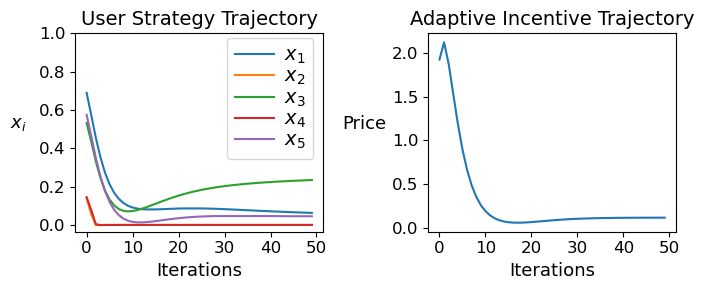

In [228]:
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.plot(x_traj[:, 0], label=r"$x_1$")
plt.plot(x_traj[:, 1], label=r"$x_2$")
plt.plot(x_traj[:, 2], label=r"$x_3$")
plt.plot(x_traj[:, 3], label=r"$x_4$")
plt.plot(x_traj[:, 4], label=r"$x_5$")

plt.xlabel("Iterations", fontsize=13)
plt.ylabel(r"$x_i$", rotation="horizontal", labelpad = 15, fontsize=13)
plt.legend(loc=1, handletextpad=0.5, labelspacing=0.05, fontsize=14, bbox_to_anchor=(1, 1.025))

plt.title("User Strategy Trajectory", fontsize=14)
plt.tick_params(axis="both", which="both", labelsize=12)
plt.yticks(np.arange(0, 1.2, 0.2))
plt.xticks(np.arange(0, 60, 10))


plt.subplot(1, 2, 2)
plt.plot(p_traj)
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Price", rotation="horizontal", labelpad = 20, fontsize=13)
plt.title("Adaptive Incentive Trajectory", fontsize=14)
plt.tick_params(axis="both", which="both", labelsize=12)
# plt.yticks(np.arange(0, 3.5, 0.5))
plt.xticks(np.arange(0, 60, 10))


plt.tight_layout()
plt.show()

### Multi-time dimensional: peak pricing case study

In [231]:
def peak_pricing_ext(x):
    z = torch.sum(x, dim=0)
    return (lambda_param)*m(ALPHA*z)

N, T = 10, 24

x = torch.rand((N, T))
x_bar = torch.rand((N, T))
lambda_param = 1

alpha_lst = torch.ones(N)
ALPHA = 100
m = nn.Softmax()
p = torch.rand(T)

player_actions = []
for j in range(N):
    curr_action = torch.rand(T) 
    player_actions.append(curr_action) 
player_actions = torch.stack(player_actions)

p_traj = []
x_traj = []

prev_actions = None 
for e in range(200):
    print('=', end='')
    for i in range(N):
        curr_action = torch.nn.Parameter(player_actions[i])
        best_response_optimizer = torch.optim.SGD([curr_action], lr = 1e-4, momentum = 0.8)
        prev_loss = torch.tensor(1e6)
        output_action = torch.relu(curr_action) 
        for epoch in range(100):
            best_response_optimizer.zero_grad()
            loss = f_i(output_action, x_bar[i], p)
            loss.backward()
            best_response_optimizer.step()
            output_action = torch.relu(curr_action)
            if torch.isclose(torch.abs(prev_loss-loss).float(), torch.tensor(float(0.0))):
                break
            else: 
                prev_loss = loss 
        player_actions[i] = gamma * output_action.detach() + (1-gamma) * player_actions[i].clone()
    externality = peak_pricing_ext(player_actions)
    p = (1-beta)*p + externality * beta

    x_traj.append(player_actions.clone())
    p_traj.append(p.clone())
    prev_actions = player_actions.clone()
equilibrium_actions = player_actions.clone()

x_traj = torch.stack(x_traj)

=

/tmp/ipykernel_101185/580954978.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return (lambda_param)*m(ALPHA*z)


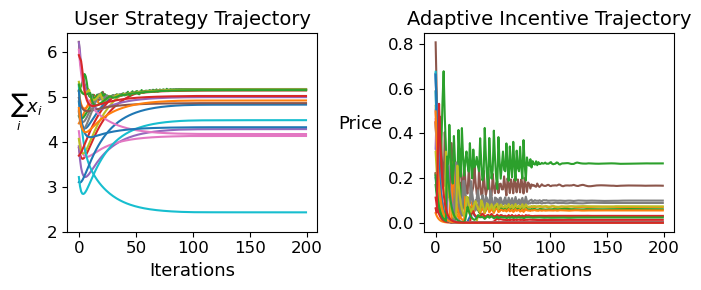

In [234]:
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)

plt.plot(torch.sum(x_traj, dim=1))
plt.xlabel("Iterations", fontsize=13)
plt.ylabel(r"$\sum_{i} x_i$", rotation="horizontal", labelpad = 15, fontsize=13)
# plt.legend(loc=1, handletextpad=0.5, labelspacing=0.1, fontsize=14)
plt.title("User Strategy Trajectory", fontsize=14)
plt.tick_params(axis="both", which="both", labelsize=12)
plt.yticks(np.arange(2, 7, 1))
plt.xticks(np.arange(0, 250, 50))


plt.subplot(1, 2, 2)
plt.plot(torch.stack(p_traj))
plt.xlabel("Iterations", fontsize=13)
plt.ylabel("Price", rotation="horizontal", labelpad = 20, fontsize=13)
plt.title("Adaptive Incentive Trajectory", fontsize=14)
plt.tick_params(axis="both", which="both", labelsize=12)
plt.yticks(np.arange(0, 1.0, 0.2))
plt.xticks(np.arange(0, 250, 50))


plt.tight_layout()
plt.show()

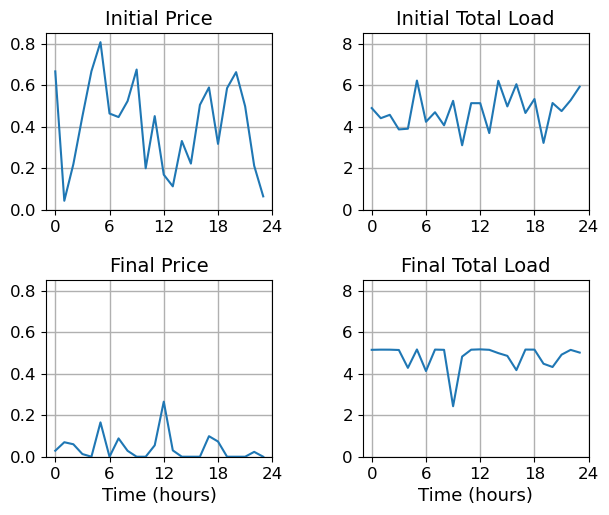

In [242]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,5.5))


ax1.plot(p_traj[0])
ax1.set_title("Initial Price", fontsize=14)
# ax1.set_xlabel("Time (hours)", fontsize=13)
ax1.tick_params(axis="both", which="major", labelsize=12)
ax1.set_xticks(np.arange(0, 30, 6))
ax1.set_yticks(np.arange(0, 1, 0.2))
ax1.set_ylim(0, 0.85)
ax1.set_xlim(-1, 24)
ax1.grid(linewidth=1)

ax2.plot(torch.sum(x_traj, dim=1)[0, :])
ax2.set_title("Initial Total Load", fontsize=14)
# ax2.set_xlabel("Time (hours)", fontsize=13)
ax2.tick_params(axis="both", which="major", labelsize=12)
ax2.set_xticks(np.arange(0, 30, 6))
ax2.set_yticks(np.arange(0, 9, 2))
ax2.set_ylim(0, 8.5)
ax2.set_xlim(-1, 24)
ax2.grid(linewidth=1)


ax3.plot(p_traj[-1])
ax3.set_title("Final Price", fontsize=14)
ax3.tick_params(axis="both", which="major", labelsize=12)
ax3.set_xlabel("Time (hours)", fontsize=13)
ax3.set_xticks(np.arange(0, 30, 6))
ax3.set_yticks(np.arange(0, 1, 0.2))
ax3.set_ylim(0, 0.85)
ax3.set_xlim(-1, 24)
ax3.grid(linewidth=1)

ax4.plot(torch.sum(x_traj, dim=1)[-1, :])
ax4.set_title("Final Total Load", fontsize=14)
ax4.set_xlabel("Time (hours)", fontsize=13)
ax4.tick_params(axis="both", which="major", labelsize=12)
ax4.set_xticks(np.arange(0, 30, 6))
ax4.set_yticks(np.arange(0, 9, 2))
ax4.set_ylim(0, 8.5)
ax4.set_xlim(-1, 24)
ax4.grid(linewidth=1)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.4)
# plt.tight_layout()